# Reflect Tables into SQLAlchemy ORM

In [23]:
# Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.sql import func
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date, timedelta
import pandas as pd
from pandas import DataFrame
from flask import Flask, jsonify

In [24]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [25]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [26]:
Base.classes.keys()

['measurement', 'station']

In [27]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [28]:
session = Session(engine)

In [29]:
columns = columns('station')
for c in columns:
    print(c['name'], c["type"])

NameError: name 'columns' is not defined

In [30]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [31]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [32]:
base_date = datetime.datetime.strptime("2017-5-25", "%Y-%m-%d")
numdays = 365
date_list = [base_date - datetime.timedelta(days=x) for x in range(0, numdays)]

In [33]:
str_dates = []
for date in date_list:
    new_date = date.strftime("%Y-%m-%d")
    str_dates.append(new_date)

In [34]:
prcp_results = session.query(func.avg(Measurement.prcp), Measurement.date)\
               .filter(Measurement.date.in_(str_dates))\
               .group_by(Measurement.date)

In [35]:
prcp_data = []
for res in prcp_results:
    prcp_data.append(res[0])

In [36]:
prcp_df = pd.DataFrame([str_dates[::-1], prcp_data[::-1]]).T
prcp_df.rename(columns={0: "Date", 1: "Precipitation"}, inplace=True)
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-05-26,0.37
2016-05-27,0.648333
2016-05-28,0.118333
2016-05-29,0.0635294
2016-05-30,0.002


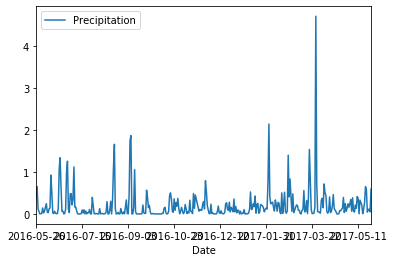

In [37]:
prcp_df.plot()
plt.savefig("Images/precipitation_analysis.png")
plt.show()

In [38]:
prcp_df["Precipitation"].describe()

count     365.0
unique    277.0
top         0.0
freq       45.0
Name: Precipitation, dtype: float64

# Station Analysis

In [39]:
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(27)

In [40]:
ob_counts = session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station)\
             .order_by(func.count(Measurement.prcp).desc())

In [41]:
#Print
for station in ob_counts:
    print(station)

top_station = ob_counts[0][0]

('USC00519281', 8316)
('USC00519397', 8133)
('USC00513117', 8114)
('USC00519523', 7910)
('USC00516128', 7708)
('USC00514830', 6341)
('USC00511918', 5890)
('USC00517948', 3427)
('USC00518838', 1364)


In [42]:
tobs_result = session.query(Measurement.tobs)\
               .filter(Measurement.date.in_(str_dates))\
               .filter(Measurement.station == top_station)
tobs_data = []
for row in tobs_result:
    tobs_data.append(row[0])

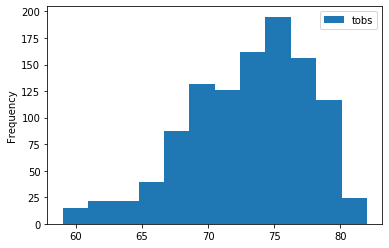

In [43]:
plt.hist(tobs_data, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend()
plt.savefig("Images/station_analysis.png")
plt.show()